In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
print("Loading dataset...")
df = pd.read_csv(r'C:\Users\Dell\Desktop\intership\myproject.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Information:")
print(df.info())

print("\nColumn names:")
print(df.columns.tolist())


Loading dataset...
Dataset shape: (573, 13)

First 5 rows:
     Age Feelinghopeless lossofinterest appetitechange distrubedsleepcycle  \
0  youth               Y              Y              Y                   Y   
1  youth               Y              Y              Y                   Y   
2  youth               Y              N              Y                   Y   
3  youth               Y              Y              Y                   Y   
4  youth               Y              Y              Y                   Y   

  low energy lackofconcentration suicidalthoughts temperoutburst panicattack  \
0          Y                   Y                Y              N           N   
1          Y                   Y                Y              N           N   
2          Y                   Y                N              N           N   
3          Y                   Y                Y              N           N   
4          Y                   Y                Y              N        

In [3]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check unique values in each column
print("\nUnique values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")



DATA PREPROCESSING

Missing values:
Age                    0
Feelinghopeless        0
lossofinterest         0
appetitechange         0
distrubedsleepcycle    0
low energy             0
lackofconcentration    0
suicidalthoughts       0
temperoutburst         0
panicattack            0
moodswing              0
medicalissue           0
type                   0
dtype: int64

Unique values in categorical columns:
Age: ['youth' 'middel-aged' 'adult']
Feelinghopeless: ['Y' 'N']
lossofinterest: ['Y' 'N']
appetitechange: ['Y' 'N']
distrubedsleepcycle: ['Y' 'N']
low energy: ['Y' 'N']
lackofconcentration: ['Y' 'N']
suicidalthoughts: ['Y' 'N']
temperoutburst: ['N' 'Y']
panicattack: ['N' 'Y']
moodswing: ['N' 'Y']
medicalissue: ['N' 'Y']
type: ['Clinical Depression' 'PDD' 'Medical Depression' 'DMDD' 'PMDD']


In [4]:
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Convert Y/N to 1/0 for binary features
binary_cols = ['Feelinghopeless', 'lossofinterest', 'appetitechange', 
               'distrubedsleepcycle', 'low energy', 'lackofconcentration', 
               'suicidalthoughts', 'temperoutburst', 'panicattack', 
               'moodswing', 'medicalissue']

for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# Encode the target variable
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])
target_names = label_encoder.classes_
print(f"Target classes: {target_names}")
print(f"Target encoding: {dict(zip(range(len(target_names)), target_names))}")

# One-hot encode Age column
df = pd.get_dummies(df, columns=['Age'], prefix='Age')

# Drop the original type column
df = df.drop('type', axis=1)



FEATURE ENGINEERING
Target classes: ['Clinical Depression' 'DMDD' 'Medical Depression' 'PDD' 'PMDD']
Target encoding: {0: 'Clinical Depression', 1: 'DMDD', 2: 'Medical Depression', 3: 'PDD', 4: 'PMDD'}



DATA EXPLORATION

Class Distribution:
Clinical Depression    158
PDD                    138
PMDD                   137
DMDD                   102
Medical Depression      38
Name: count, dtype: int64


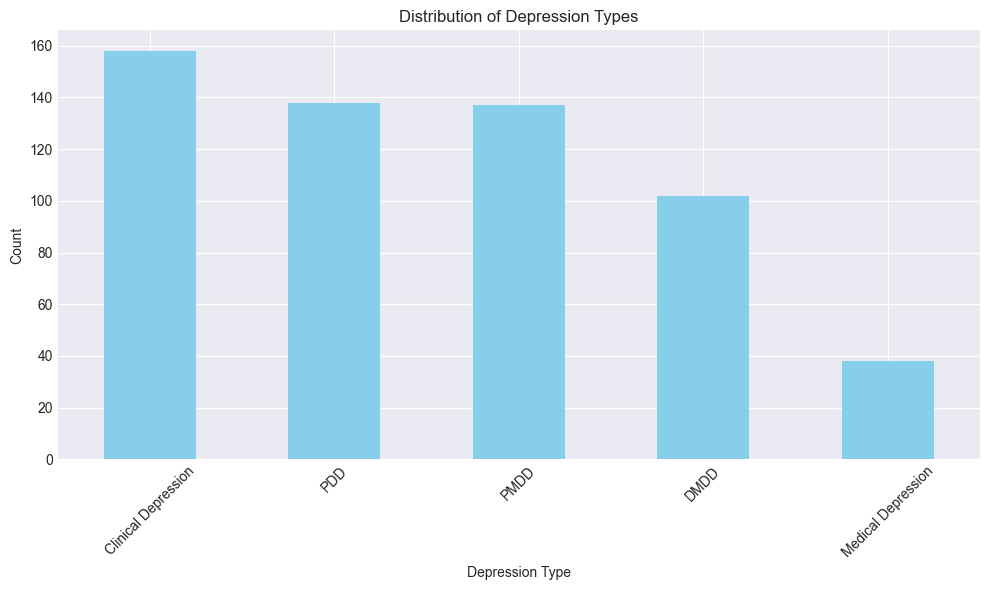

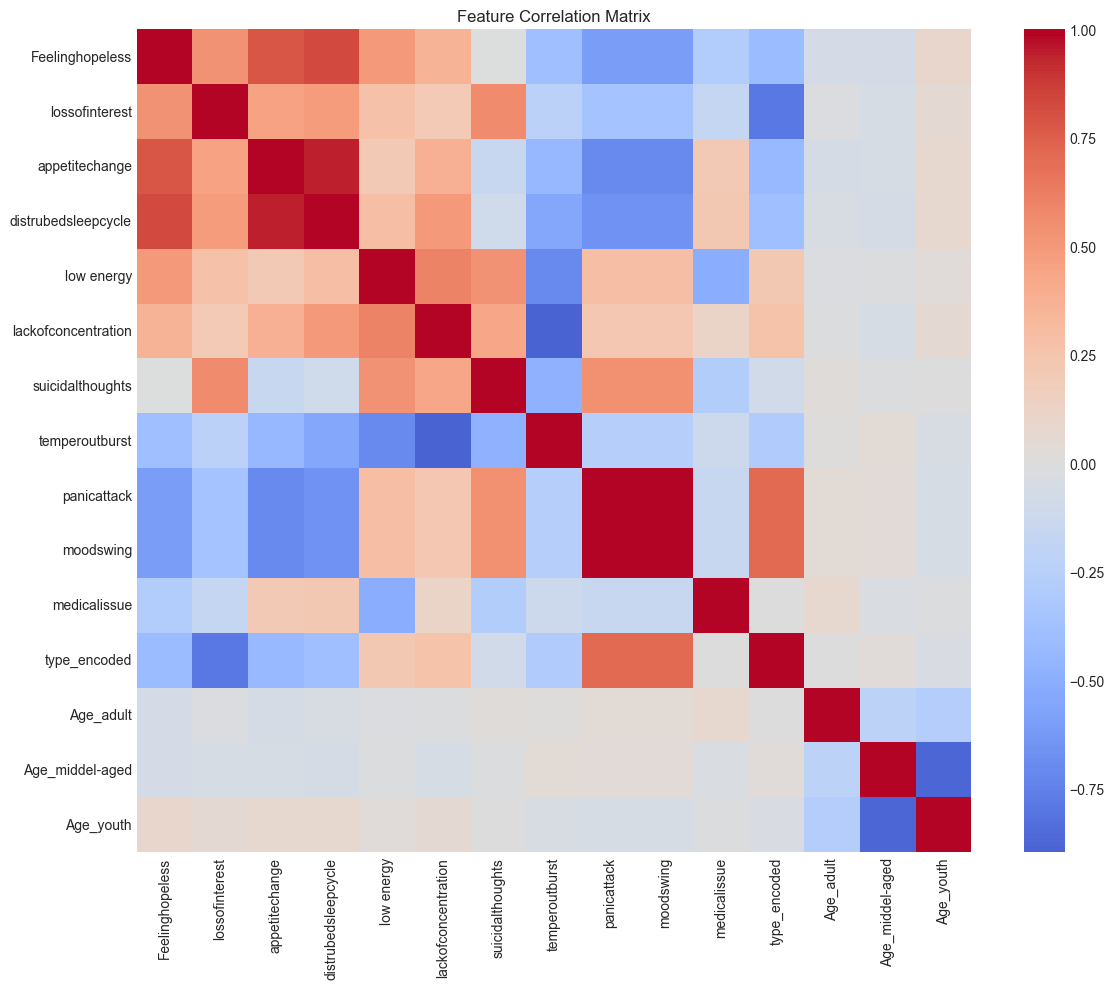

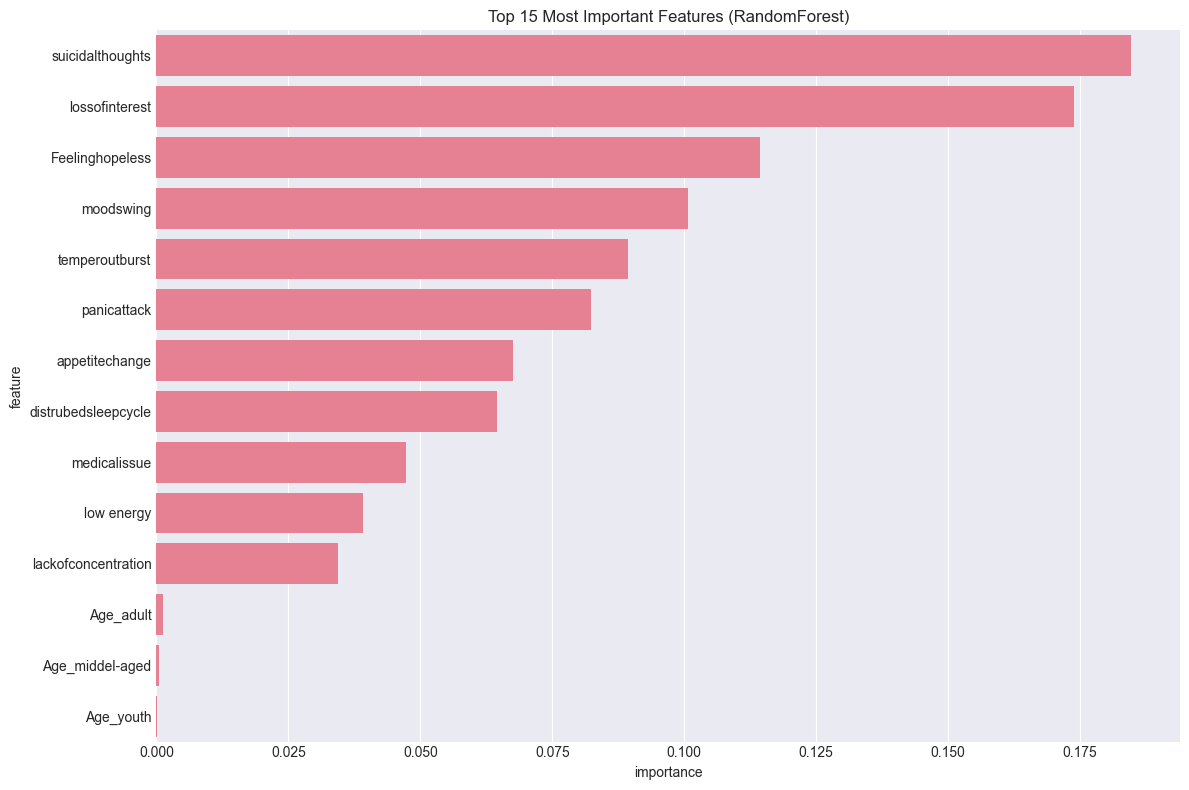

In [5]:
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Check class distribution
original_target = label_encoder.inverse_transform(df['type_encoded'])
class_distribution = pd.Series(original_target).value_counts()
print("\nClass Distribution:")
print(class_distribution)

plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Depression Types')
plt.xlabel('Depression Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Feature importance (using RandomForest for initial assessment)
X_temp = df.drop('type_encoded', axis=1)
y_temp = df['type_encoded']

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_temp)

feature_importance = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features (RandomForest)')
plt.tight_layout()
plt.show()


In [6]:
print("\n" + "="*50)
print("MODEL PREPARATION")
print("="*50)

# Separate features and target
X = df.drop('type_encoded', axis=1)
y = df['type_encoded']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check for class imbalance
print("\nClass distribution (encoded):")
print(pd.Series(y).value_counts())

# Handle class imbalance using SMOTE
print("\nApplying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"After SMOTE - Features shape: {X_resampled.shape}")
print(f"After SMOTE - Target shape: {y_resampled.shape}")
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


MODEL PREPARATION
Features shape: (573, 14)
Target shape: (573,)

Class distribution (encoded):
type_encoded
0    158
3    138
4    137
1    102
2     38
Name: count, dtype: int64

Applying SMOTE to handle class imbalance...
After SMOTE - Features shape: (790, 14)
After SMOTE - Target shape: (790,)

Class distribution after SMOTE:
type_encoded
0    158
3    158
2    158
1    158
4    158
Name: count, dtype: int64

Training set size: (632, 14)
Testing set size: (158, 14)



MODEL TRAINING AND EVALUATION

Training Random Forest...
Random Forest - Accuracy: 1.0000, F1-Score: 1.0000

Classification Report for Random Forest:
                     precision    recall  f1-score   support

Clinical Depression       1.00      1.00      1.00        32
               DMDD       1.00      1.00      1.00        31
 Medical Depression       1.00      1.00      1.00        32
                PDD       1.00      1.00      1.00        32
               PMDD       1.00      1.00      1.00        31

           accuracy                           1.00       158
          macro avg       1.00      1.00      1.00       158
       weighted avg       1.00      1.00      1.00       158


Training Gradient Boosting...
Gradient Boosting - Accuracy: 1.0000, F1-Score: 1.0000

Classification Report for Gradient Boosting:
                     precision    recall  f1-score   support

Clinical Depression       1.00      1.00      1.00        32
               DMDD       1.00      1.00  

<Figure size 1200x600 with 0 Axes>

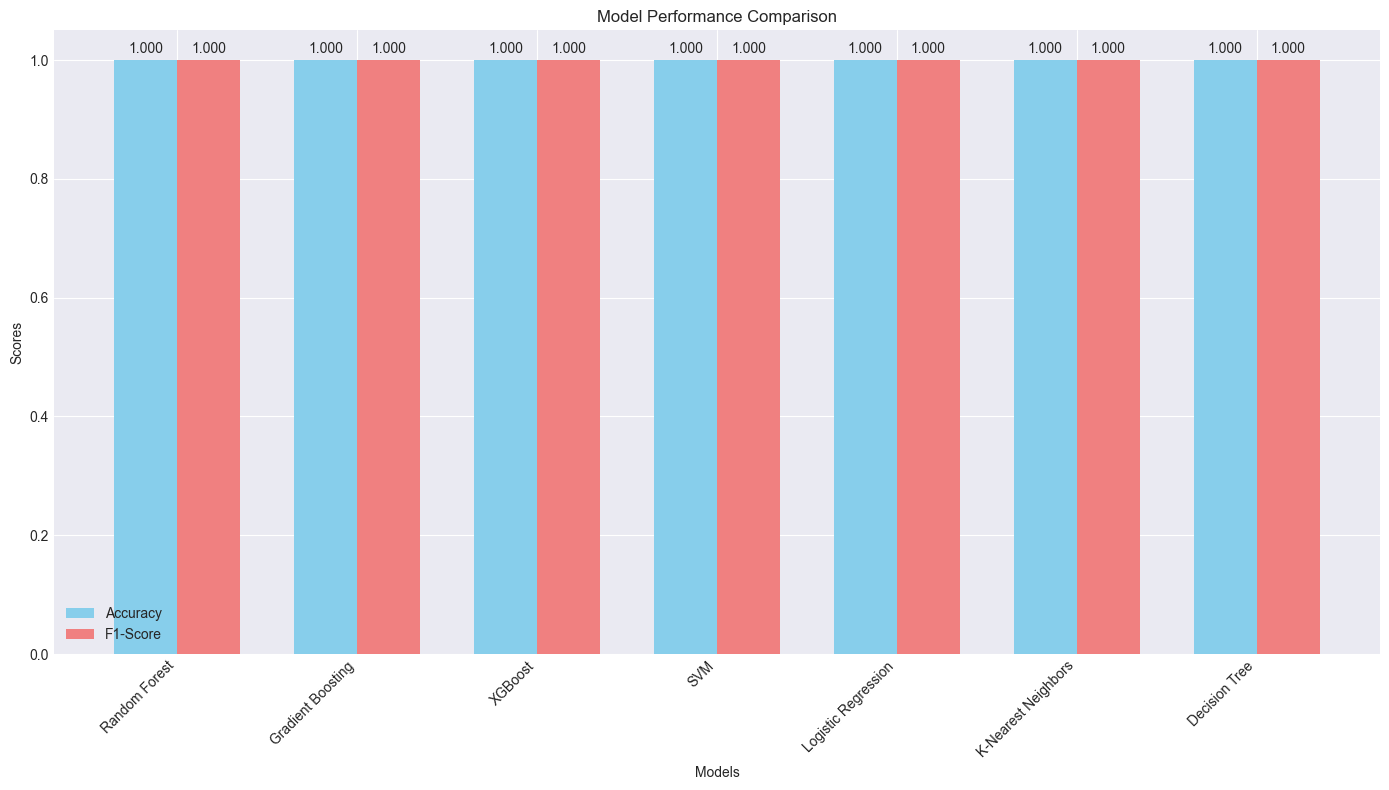

In [7]:
print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# Define models to try
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
    
    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=target_names))

# Compare model performance
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
}).sort_values('Accuracy', ascending=False)

print(results_df)

# Visualize model comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, results_df['F1-Score'], width, label='F1-Score', color='lightcoral')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()



HYPERPARAMETER TUNING
Best model: Random Forest
Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 1.0000

FINAL EVALUATION
Final Model: Random Forest
Accuracy: 1.0000
F1-Score: 1.0000


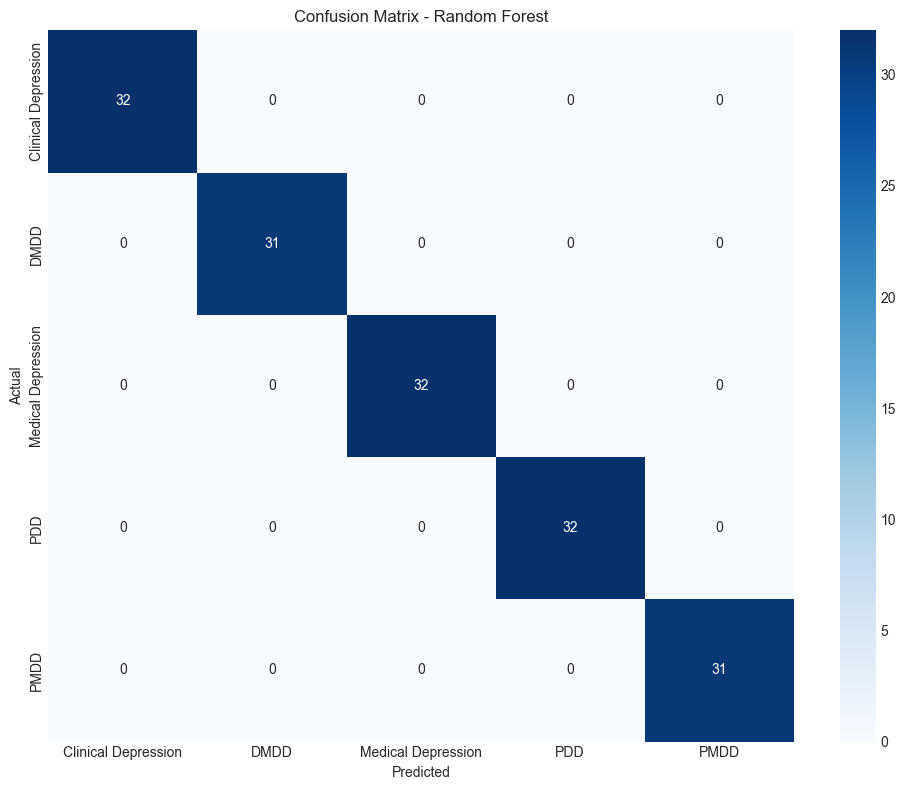

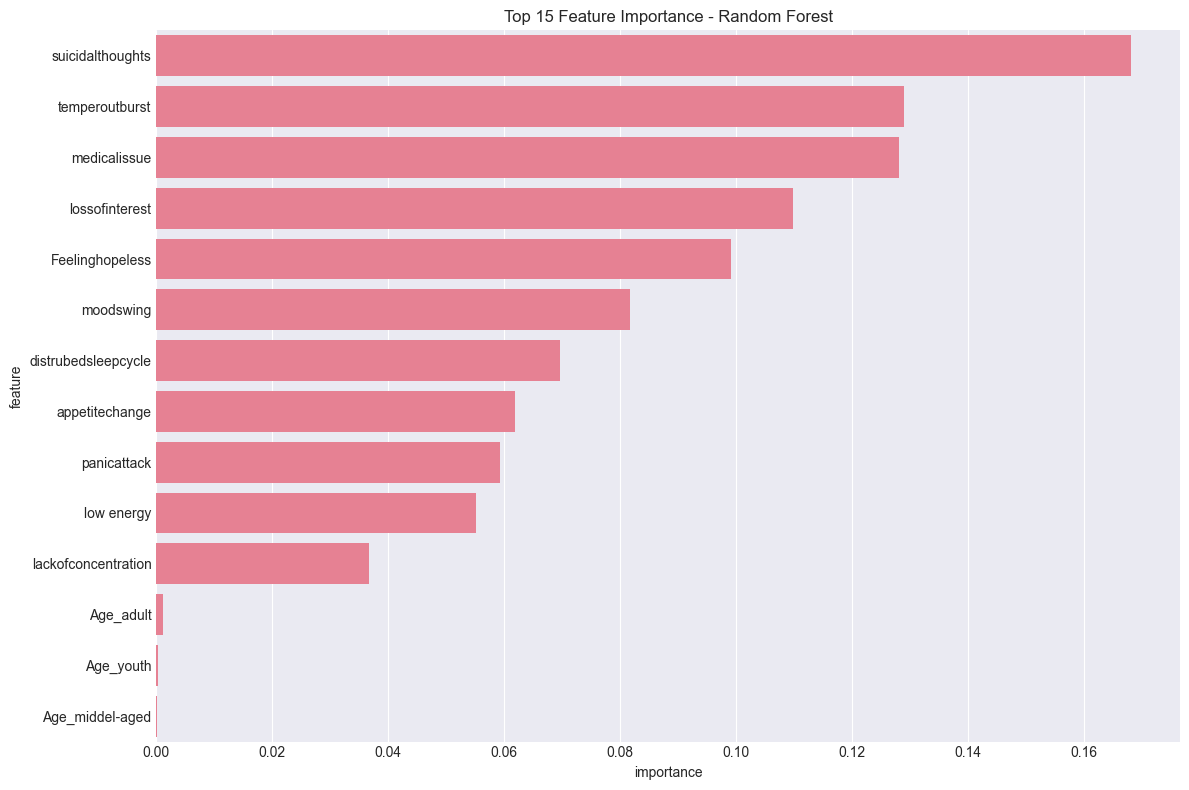


Top 10 most important features:
                feature  importance
6      suicidalthoughts    0.168215
7        temperoutburst    0.128939
10         medicalissue    0.128122
1        lossofinterest    0.109803
0       Feelinghopeless    0.099186
9             moodswing    0.081803
3   distrubedsleepcycle    0.069566
2        appetitechange    0.061835
8           panicattack    0.059214
4            low energy    0.055082


In [8]:
print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

# Select the best model based on accuracy
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"Best model: {best_model_name}")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
else:
    param_grid = {}  # Skip tuning for other models

if param_grid:
    print(f"Performing GridSearchCV for {best_model_name}...")
    grid_search = GridSearchCV(
        best_model,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Use the best estimator
    best_model = grid_search.best_estimator_
else:
    print(f"Skipping hyperparameter tuning for {best_model_name}")

# 9. Final Evaluation on Test Set
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Make predictions with the best model
y_pred_final = best_model.predict(X_test_scaled)

# Calculate final metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final, average='weighted')

print(f"Final Model: {best_model_name}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1-Score: {final_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance_final = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_final.head(15))
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 most important features:")
    print(feature_importance_final.head(10))


In [9]:
print("\n" + "="*50)
print("CROSS-VALIDATION")
print("="*50)

cv_scores = cross_val_score(best_model, X_resampled, y_resampled, 
                           cv=5, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



CROSS-VALIDATION
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000 (+/- 0.0000)
